In [15]:
import numpy as np
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.control_flow import scan

import matplotlib.pyplot as plt
import jax

In [28]:

def bsts_model(y, x, T_forecast):
    T = len(y)
    
    # Priors
    sigma_mu = numpyro.sample("sigma_mu", dist.HalfCauchy(1))
    sigma_tau = numpyro.sample("sigma_tau", dist.HalfCauchy(1))
    sigma_y = numpyro.sample("sigma_y", dist.HalfCauchy(1))
    beta = numpyro.sample("beta", dist.Cauchy(0, 1))

    # Local trend
    mu_err = numpyro.sample("mu_err", dist.Normal(0, sigma_mu).expand([T]))
    mu = numpyro.deterministic("mu", jnp.cumsum(mu_err))

    # Seasonality
    tau_err = numpyro.sample("tau_err", dist.Normal(0, sigma_tau).expand([T]))
    tau = numpyro.deterministic("tau", jnp.zeros(T))
    tau = tau.at[0:4].set(tau_err[0:4])
    
    def update_tau(carry, t):
        tau_prev = carry
        tau_t = -(tau_prev[t-1] + tau_prev[t-2] + tau_prev[t-3] + tau_prev[t-4]) + tau_err[t]
        return tau_prev.at[t].set(tau_t), None

    tau, _ = scan(update_tau, tau, jnp.arange(4, T))

    # Likelihood
    numpyro.sample("y", dist.Normal(mu + tau, sigma_y), obs=y)

    # Forecast
    mu_forecast = numpyro.sample("mu_forecast", 
                                 dist.Normal(mu[-1], sigma_mu * jnp.sqrt(jnp.arange(1, T_forecast+1))),
                                 sample_shape=(T_forecast,))
    
    tau_forecast = numpyro.sample("tau_forecast", 
                                  dist.Normal(0, sigma_tau),
                                  sample_shape=(T_forecast,))
    
    def update_tau_forecast(carry, t):
        tau_prev = carry
        if t < 4:
            tau_t = -(tau[-4+t:].sum() + tau_prev[:t].sum()) + tau_forecast[t]
        else:
            tau_t = -(tau_prev[t-1] + tau_prev[t-2] + tau_prev[t-3] + tau_prev[t-4]) + tau_forecast[t]
        return tau_prev.at[t].set(tau_t), None

    tau_forecast, _ = scan(update_tau_forecast, tau_forecast, jnp.arange(T_forecast))

    y_forecast = numpyro.sample("y_forecast", 
                                dist.Normal(mu_forecast + tau_forecast, sigma_y),
                                sample_shape=(T_forecast,))

# To run the model:
# num_warmup, num_samples = 1000, 2000
# mcmc = MCMC(NUTS(bsts_model), num_warmup=num_warmup, num_samples=num_samples)
# mcmc.run(jax.random.PRNGKey(0), y=y_data, x=x_data, T_forecast=T_forecast)
# mcmc.print_summary()

Let's break it down into several parts:

Data and Parameters:
* $y_t$: observed value at time $t$, $t = 1, ..., T$
* $x_t$: covariate at time $t$, $t = 1, ..., T + T_{forecast}$

Parameters:
* $\sigma_\mu, \sigma_\tau, \sigma_y, \beta$

State Space Components:
* $\mu_t$: local trend
* $\tau_t$: seasonality component



Model Specification:

$$
\begin{align*}
\text{Priors:} \\
\sigma_\mu, \sigma_\tau, \sigma_y &\sim \text{Cauchy}^+(0, 1) \\
\beta &\sim \text{Cauchy}(0, 1) \\[10pt]
\text{State Equations:} \\
\mu_t &= \mu_{t-1} + \epsilon_{\mu,t}, \quad \epsilon_{\mu,t} \sim \mathcal{N}(0, \sigma_\mu^2) \\[5pt]
\tau_t &=
\begin{cases}
\epsilon_{\tau,t}, & \text{if } t \leq 4 \\
-(\tau_{t-1} + \tau_{t-2} + \tau_{t-3} + \tau_{t-4}) + \epsilon_{\tau,t}, & \text{if } t > 4
\end{cases} \\
&\quad \text{where } \epsilon_{\tau,t} \sim \mathcal{N}(0, \sigma_\tau^2) \\[10pt]
\text{Observation Equation:} \\
y_t &\sim \mathcal{N}(\mu_t + \tau_t, \sigma_y^2)
\end{align*}
$$



Forecast Equations:
For $t = 1, ..., T_{forecast}$:
$$
\begin{align*}
\mu_{T+t} &\sim \mathcal{N}(\mu_{T+t-1}, \sigma_\mu^2) \\[5pt]
\tau_{T+t} &=
\begin{cases}
-(\tau_{T+t-1} + \tau_{T+t-2} + \tau_{T+t-3} + \tau_{T+t-4}) + \epsilon_{\tau,T+t}, & \text{if } t > 4 \\
-(\sum_{i=1}^{t-1} \tau_{T+i} + \sum_{i=t}^4 \tau_{T-4+i}) + \epsilon_{\tau,T+t}, & \text{if } t \leq 4
\end{cases} \\
&\quad \text{where } \epsilon_{\tau,T+t} \sim \mathcal{N}(0, \sigma_\tau^2) \\[5pt]
y_{T+t} &\sim \mathcal{N}(\mu_{T+t} + \tau_{T+t}, \sigma_y^2)
\end{align*}
$$

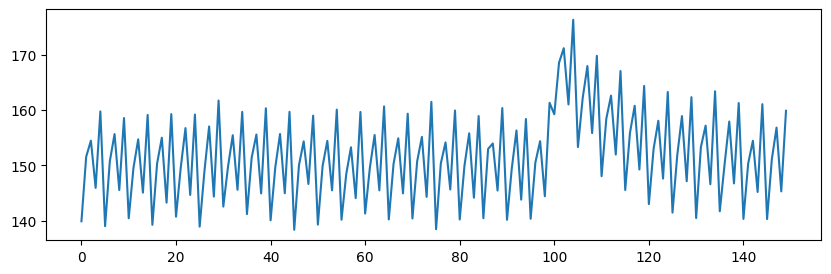

In [29]:
# Sim data
x = np.zeros(150)
beta = 1
mu = np.random.normal(150, 1, 150)
tau = np.tile(np.asarray([-10,0,5,-5,10]),30)
treatment = np.concatenate((np.zeros(100),20*np.exp(-0.08*np.arange(50))))
y = mu+tau+treatment+x*beta

fig,ax = plt.subplots(figsize=(10,3))
ax.plot(y)
plt.show()

In [30]:

num_warmup, num_samples = 1000, 2000
mcmc = MCMC(NUTS(bsts_model), num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(random.PRNGKey(0), y=y, x=x, T_forecast=5)
mcmc.print_summary()

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function body_fn at /home/nelsont/.cache/pypoetry/virtualenvs/pymc-statespace-W4oADPxQ-py3.10/lib/python3.10/site-packages/numpyro/contrib/control_flow/scan.py:282 for scan. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError